# Stylistics and Document Clustering

In "Stylistic Analysis and Authorship Studies" (2004), Hugh Craig describes stylistics as an "open-ended and exploratory" approach that "aims to bring to light patterns in style which influence readers' perceptions and relate to the disciplinary concerns of literary and linguistic interpretation." Craig's description recognizes two important and interlinking facets of text: disciplinary modes of interpretation and style. I like the attention to style as a concept that refracts in two directions: the text and the reader's perception of the text. Although these notebook are meant to be focused on writing and using code, it is important to remember how disciplinary knowledge shapes interpretation and, therefore, obscures as much as it illuminates.

In this notebook, we'll begin to work with a major method in both stylistic analysis and information retrieval: term frequency-inverse document frequency. Tf-idf tries to account for the problem mentioned in the last notebook, which is raw word counts will disproportionately favor words in longer texts. Tf-idf, instead, tries to weighs how important a word is to the document it appears in. Importance is measured by the word's frequency divided by the number of documents that contain the word. The [Wikipedia entry for tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is quite clear if you'd like a longer explanation. For a more detailed explanation of tf-idf and an alternative Python script, look at Matthew J. Lavin's "[Analyzing Documents with TF-IDF](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf)" at the Programming Historian.

With our text data transformed to numerical representations (tf-idf), we can then use that information to cluster texts and try to discover general patterns of real and fake news. To do this, we'll use principal component analysis. Principal Component Analysis (PCA), which is also explained well on [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis), is a method of reducing data to its most significant dimensions. How is a dimension of data considered significant, though? Dimensions of data measure the variation within that data. If the variation between data values is high, then that dimension could be deemed significant. If the variation is low—that is each value does not differ much from the other values—then could be considered less significant.

Although we're starting to wade into more advanced methods, there are two simple takeaways that tf-idf and PCA try to get at. The first is probably intuitive at this point: the words in a document say something about that document, such as its subject matter or style. We can then extrapolate out from one text and compare the style of many texts to learn about latent cultural patterns and trends. Tf-idf happens to be a very good way to accomplish the first task while PCA is good at the second.

### Goals
1. Transform text to numerical information with sklearn's TfidfVectorizer.
2. Demonstrate text clustering with principal component analysis (PCA).

In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

abs_dir = "/Users/williamquinn/Desktop/DH/Python/Teaching/Python-Notebooks/"

In [2]:
data = pd.read_csv(abs_dir + "data/dataframe.csv",
                   sep = ",")

print (data.shape)
data.head()

(57887, 6)


,title,text,subject,date,veracity,dataset
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,real,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,real,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,real,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,2017-12-30,real,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,2017-12-29,real,0


Before we transform our text to data, let's first clean some of it. For example, we might be worried that the publication byline ("WASHINGTON (Reuters)") is so repetitive that it will become the key distinction between real and fake news. 

## Routine Text Normalization and Cleaning

We also want to lower our text (.str.lower()) and remove extra whitespace (\s+) so that words with varying capitalization aren't treated as different words.

In [4]:
# We can remove the byline, remove any extra whitespace, and lower case the text.
data['text'] = data['text'] \
    .replace(r"[A-Z/]+ \(\w+\) - ", "", regex=True) \
    .replace(r'\s+', ' ', regex=True) \
    .str.lower() \
    .astype(str)

data.head()

,title,text,subject,date,veracity,dataset,class_id
0,"As U.S. budget fight looms, Republicans flip t...",the head of a conservative republican faction ...,politicsNews,2017-12-31,real,0,0
1,U.S. military to accept transgender recruits o...,transgender people will be allowed for the fir...,politicsNews,2017-12-29,real,0,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,the special counsel investigation of links bet...,politicsNews,2017-12-31,real,0,0
3,FBI Russia probe helped by Australian diplomat...,trump campaign adviser george papadopoulos tol...,politicsNews,2017-12-30,real,0,0
4,Trump wants Postal Service to charge 'much mor...,president donald trump called on the u.s. post...,politicsNews,2017-12-29,real,0,0


### Text Representation

Transform text into numerical values (numerical feature vectors).

Tf-idf is numerical statistic that indicates the significance of a word within a document. Words that appear frequently in many documents, such as "the," have a low score (close to zero). Words that appear infrequently, such as hapax legomenon, or only in a few documents have a higher score (close to one).

In [5]:
%%time

# Instantiate a vectorizer.
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=0.1, 
                        max_df=0.9, 
                        stop_words='english',
                        encoding='latin-1', 
                        ngram_range=(1, 2))

features = tfidf.fit_transform(data['text']).toarray()

# Create labels.
labels = data[str(class_to_predict)]

# Show data size.
features.shape

CPU times: user 1min 18s, sys: 2.97 s, total: 1min 21s
Wall time: 1min 24s


(57887, 202)

You might notice that TfidfVectorizer() looks very similar to the CountVectorizer() from the last notebook. Both have many of the same arguments.

```python
sublinear_tf = True
```
This argument scales the frequency of terms for a smoother gradation (1 + log(tf)).

```python
min_df = 0.1, max_df = 0.9
```
The min and max arguments set the lower and upper bounds of word limits. If a word doesn't appear between these two fractions (10% and 90%) it is ignored.

```python
stop_words='english'
```
Remove English stopwords.

```python
encoding = 'latin-1'
```
This argument sets the text string to a specific encoding. When working with texts, you'll find that a string can be encoded in different formats. A common encoding is 'utf-8'. Encoding arguments tend to force a string into a specific encoding format. If there's a character that cannot be changed, it can be ignored.

```python
ngram_range = (1, 2)
```
Ngrams are ranges of words. A single ngram is a single word. A bigram is every sequence of two words. For example, a bigram list of this description would look like:

```python
[('Ngrams','are'), ('are','ranges'), ('ranges', 'of')]
```
Bigrams are pairs of words that appear together. Ngrams can refer to any number of ranges.

## Clustering

Clustering is an unsupervised method of grouping data that share similar values. It is unsupervised because we don't provide it labels beforehand. Unsupervised methods try to find groups within data on its own. Of course, how we construct a dataset will have the biggest part in determining what can be grouped within our analysis. But, after corpus construction, an unsupervised method will try to cluster similar entities together.

Principal Component Analysis (PCA) is an effective approach when dealing with complex data. Looking at features.shape above, we know that we have ~60,000 documents (rows) each with 202 dimensions (columns)—that's a little over 12 million values. PCA will try to reduce that data to its key dimensions so that we can plot documents into 2D space. As PCA iterates over data, it will try to find the dimensions that express the most variability and, therefore, convey the most distinguishing factors amongst documents.

In [6]:
# Set the number of principal components we want.
pca = PCA(n_components=2)

# Determine principal components in our features matrix.
principalComponents = pca.fit_transform(features)

# Transform principal components to a dataframe format.
principalDf = pd.DataFrame(data = principalComponents,
                           columns = ['PC1', 'PC2'])

# Join principal components with metadata (veracity column in our "data" dataframe).
finalDf = pd.concat([principalDf, data[['veracity']]], axis = 1)

finalDf

,PC1,PC2,veracity
0,0.035109,0.270546,real
1,-0.100746,0.238731,real
2,0.164334,0.220234,real
3,0.098865,0.294564,real
4,-0.058824,0.142281,real
...,...,...,...
57882,-0.004314,-0.207815,fake
57883,-0.083947,-0.150840,fake
57884,-0.083947,-0.150840,fake
57885,-0.078808,-0.176767,fake


We can now imagine PC1 and PC2 now acting as our x and y coordinates and visualize them on a 2D graph, using color to distinguish between real and fake articles.

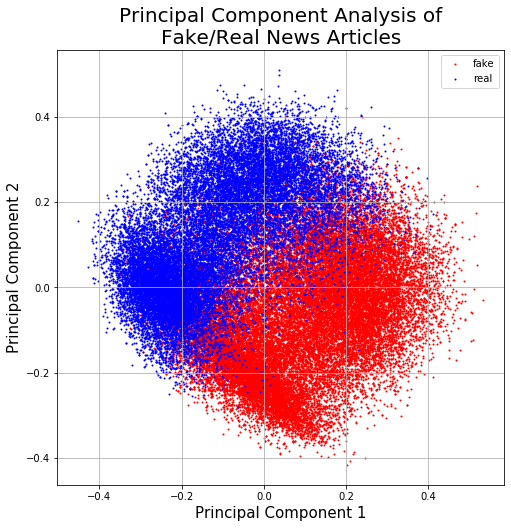

In [7]:
fig = plt.figure(figsize = (8,8))

# Here, we're changing the style, font size, and format of our graph labels and titles.
ax = fig.add_subplot(1, 1, 1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Component Analysis of\nFake/Real News Articles', fontsize = 20)

# Manually set our "targets," the values we want to color.
# Set the colors (red and blue).
targets = ['fake', 'real']
colors = ['r', 'b']

# We'll first iterate through our two lists (targets and colors) binding them together with zip()
for target, color in zip(targets, colors):
#     Then, we'll make a new variable (indicesToKeep), which
    indicesToKeep = finalDf['veracity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'],
               finalDf.loc[indicesToKeep, 'PC2'],
               c = color,
               s = 1)
    
ax.legend(targets)
ax.grid()

Our visualization suggests that the unsupervised learning has identified a linguistic difference between fake and real news. Again, though, this does not mean we've discovered some inherent difference between real news and fake news. Instead, we're learning something (linguistically) specific about our dataset that we might possible extrapolate to explain larger cultural clues about language and writing.

### Explained Variance

Visualizations can be misleading, though. To better understand the information reduction of PCA, we can use .explained_variance_ratio. The explained variance tells how much information each component accounts for within the data. Explained variance offers a more precise way of knowing whether the principal components describe a large or small portion of the variation within data.

In [10]:
print (pca.explained_variance_ratio_.sum())

pca.explained_variance_ratio_

0.06945930850968585


array([0.03761236, 0.03184695])

Our first component contains 3.7% of our data's variation while the second is only 3.1%. This is very low and contextualizes the visualization above. So, when we visualize the principal components of our data, we're only looking at 6.9%. That is, the visualization above masks the fact that we're only considering a very small portion of our entire dataset. With so little information accounted for, we should be very hesitant to draw conclusions from our visualization.

## Conclusion

This notebook has covered how to transform text documents (in a pandas dataframe) into numerical representations that can be analyzed. This is often the first step of any large scale text analysis and can be used in numerous other ways. The Principal Component Analysis (PCA) is a data reduction method to see key dimensions of a corpus, but it comes with certain risks. As these notebooks move into more advanced methods, it should become clearer that domain knowledge—specialized knowledge of the content of data—is critical. Data analysis, of any kind, should regularly consult specialist in the field that the data seems to describe.


#### Works Cited
* Craig, Hugh, "Stylistic Analysis and Authorship Studies," <i>A Companion to Digital Humanities</i>, ed. Susan Schreibman, Ray Siemens, John Unsworth. Oxford: Blackwell, 2004.http://www.digitalhumanities.org/companion/
* Galarnyk, Michael, "PCA using Python (scikit-learn)," <i>towards data science</i>, Dec. 4, 2017, Accessed May 12, 2020, https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60.
* Lavin, Matthew J., "[Analyzing Documents with TF-IDF](https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf)," <i>The Programming Historian</i>, Accessed May 15, 2020.